
# **Mounted Google Drive**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Bidirectional
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [3]:
data = pd.read_parquet('C:/Users/ASUS ROG/Desktop/model-ai/yellow_tripdata_2013-01.parquet')


In [4]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2013-01-01 00:39:00,2013-01-01 00:55:00,3,3.86,1,None,238,116,2,15.0,0.5,0.5,0.00,0.0,0.0,16.00,None,None
1,2,2013-01-01 00:12:00,2013-01-01 00:16:00,5,0.00,1,None,264,264,1,3.5,0.5,0.5,0.12,0.0,0.0,4.62,None,None
2,2,2013-01-01 00:02:00,2013-01-01 00:03:00,3,0.00,1,None,264,264,1,2.5,0.5,0.5,0.25,0.0,0.0,3.75,None,None
3,2,2013-01-01 00:38:00,2013-01-01 00:38:00,2,0.00,1,None,264,264,2,2.5,0.5,0.5,0.00,0.0,0.0,3.50,None,None
4,2,2013-01-01 00:03:00,2013-01-01 00:04:00,4,0.00,1,None,264,264,1,3.0,0.5,0.5,0.07,0.0,0.0,4.07,None,None


In [8]:
data.shape

(14776617, 19)

In [9]:
data = data[:100000]

In [10]:
data.shape

(100000, 19)

In [11]:
# Drop rows with NaN values in critical columns
data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount'], inplace=True)


C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_5288\2583498939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount'], inplace=True)


In [12]:
# Convert datetime columns
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')


C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_5288\1936027084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_5288\1936027084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')


In [13]:
# Drop rows where datetime conversion failed
data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)

C:\Users\ASUS ROG\AppData\Local\Temp\ipykernel_5288\1491229934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)


In [14]:
# Filter rows with valid trip distances and fare amounts
data = data[(data['trip_distance'] > 0) & (data['fare_amount'] > 0)]

In [15]:
# Calculate trip duration in minutes
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60


In [16]:
# Create derived columns for hour and day of the week
data['hour'] = data['tpep_pickup_datetime'].dt.hour
data['day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek

In [17]:
# Standardize trip_distance and trip_duration
scaler = StandardScaler()
data[['trip_distance', 'trip_duration']] = scaler.fit_transform(data[['trip_distance', 'trip_duration']])

In [18]:
# Prepare features and target variable
X = data[['trip_distance', 'hour', 'day_of_week']]
y = data['fare_amount']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Reshape data for LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)

c:\Users\ASUS ROG\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 60.0460
Epoch 2/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 15.4192
Epoch 3/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 14.9294
Epoch 4/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 14.3430
Epoch 5/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 14.9285
Epoch 6/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 14.6912
Epoch 7/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 15.9760
Epoch 8/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 14.8533
Epoch 9/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 15.3833
Epoch 10/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 13.4317


In [33]:
y_pred = model.predict(X_test_lstm)

621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


In [34]:
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)


ValueError: Found input variables with inconsistent numbers of samples: [1000, 19866]

In [35]:
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Check the shape of X_train and y_train
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Reshape data for LSTM (assuming the correct number of samples)
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Make sure y_train and y_test match the number of samples in X_train_lstm and X_test_lstm
print(X_train_lstm.shape, y_train.shape)
print(X_test_lstm.shape, y_test.shape)

# LSTM Model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)

# Make predictions
y_pred = model.predict(X_test_lstm)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared score:", r2)


(79464, 3) (79464,)
(1000, 3) (1000,)
(79464, 1, 3) (79464,)
(1000, 1, 3) (1000,)


c:\Users\ASUS ROG\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 57.7645
Epoch 2/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 17.1194
Epoch 3/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 14.3068
Epoch 4/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 14.4322
Epoch 5/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 14.3524
Epoch 6/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 14.1089
Epoch 7/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 14.4218
Epoch 8/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 14.2662
Epoch 9/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 14.0983
Epoch 10/10
2484/2484 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 14.8584
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
R-squared score: -0.780540987994367


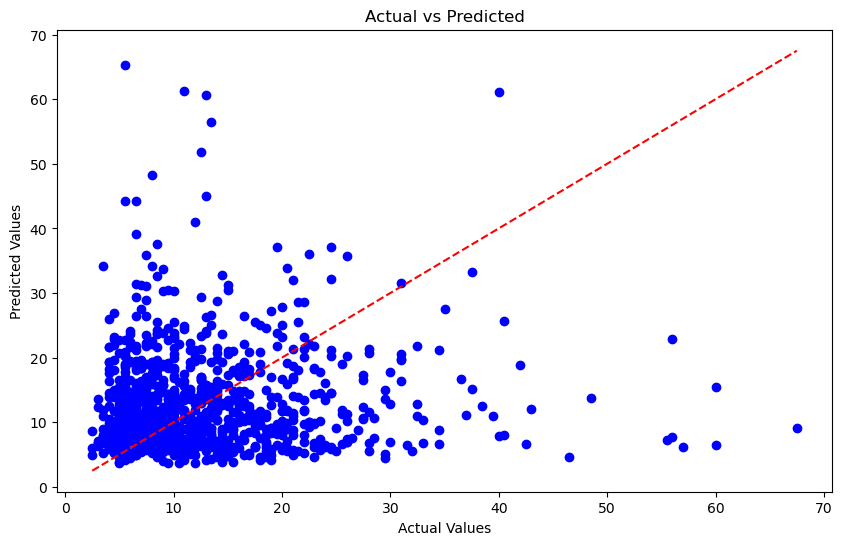

In [36]:
# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()